# 09.02 Ensembles

Training several trees and then bagging them together makes up for several
the issues with decision trees.
Thanks to that the Random Forest,
a forest of randomized decision trees,
is a very powerful ensemble classifier.

Such ensembles are some of the most powerful classifiers,
these can draw very fluid decision boundaries between several classes at once.

![Moons of Jupiter](sl-jupiter.svg)

<div style="text-align:right;"><sup>sl-jupiter.svg</sup></div>

<div style="border: 0.3em double teal; border-radius: 0.5em; padding: 0.5em;">
    Jupiter has many moons,
    at the time of writing we know of 79 objects orbiting the planet which are
    considered to be moons.
    But perhaps the four best known moons are the Galilean Moons:
    Callisto, Europa, Ganymede and Io.
    These four moons have been registered by Galileo Galilei in the early 17th century.
    The dots in the Jupyter logo represent these moons but only three of the moons
    are visible because at the time of creation of the Jupyter project only three
    languages were supported: Julia, Python and R.
</div>

For a start we import the usual stuff and also two ensemble models.
Ensemble models will train several models instead of a single one,
and then predict from each model and average the results.
There are several ways in which groups of models can be trained,
and different ensemble techniques perform often very different schemes.

The Random Forest trains trees on subsamples of data,
whilst Ada Boost trains several model one based on the results of the
previous model.
Most commonly Ada Boost is used with trees but other models are also possible.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

### Random Forest

Is the technique of training several trees on subsamples of the data,
i.e. each tree does not see the full dataset.
Then we take the majority vote when predicting.
Apart from varying the number of samples each tree will see only a subset of features,
A *random forest* trains several trees each on a sub-sample of the data
and a sub-sample of the features.
The sub-sampling can be performed *bootstrapped* (the default in `sklearn`) or not.
Bootstrapping means selecting from the dataset *with replacement*.
The bootstrapped means that each tree sees as many points as the dataset has
but some of the points are likely duplicates since the selection
of the subsamples is with replacement.

The higher randomization increases the variance of the model.
But the fact that we train several models and then take the majority vote
reduces the variance again.
The big advantage of random forests and bagging is the fact that
each ensemble model can be trained separately.
Which also means that it is easy to parallelize the algorithm across processes or even machines.
When using several trees at once
we lose the capacity of explaining what the model is doing (white-box),
hence the random forest is a black-box model - a model which classification
decision is hard to explain by looking at the model itself.

### Ada Boost

Boosting algorithms take a slightly different approach.
They train a very simple model,
e.g. a tree that can only split the data once (also called a tree stump).
Then the boosting algorithm finds the samples that the very simple model got wrong,
and updates the data set to put more weights to these samples.
Remember that in most cases in machine learning we have equations
where we sum over the data, to put more weight on certain data points
we just add a multiplier higher than $1$ against these data points.

Then the boosting algorithm trains a new very simple model (e.g. stump)
on the new, updated, dataset.
It is likely that the new model will classify/regress the weighted samples correctly,
at the expense of the other samples.
On the next step the boosting algorithm again evaluates the just trained simple model,
and find the samples that this new model got wrong.
Now the algorithm puts more weight on the samples badly predicted by the newest
model and trains yet another simple model on that set.
The algorithm repeats until the maximum number of simple models is reached.

The final answer from the algorithm is either a majority vote, or a weighted vote
(weighted by amount of error of each model or by predicted probabilities).

Ada Boost is the original algorithm, with several variants following it.
In general, boosting produces a good representation of the dataset structure,
which means that is produces very good generalization to new datasets.
Yet, the fact that the ensemble construction by boosting cannot be parallelized
makes the algorithm less practical for use with very big datasets.

---

In order to look at a non-linear problem we again we build our four moon data generator.

In [2]:
def make_four_moons(n, noise):
    X_left, y_left = make_moons(n//2, noise=noise)
    X_right, y_right = make_moons(n//2, noise=noise)
    X_right[:, 0] += 3
    y_right[:] += 2
    X = np.vstack((X_left, X_right))
    y = np.hstack((y_left, y_right))
    return X, y

And we can have a look at it.

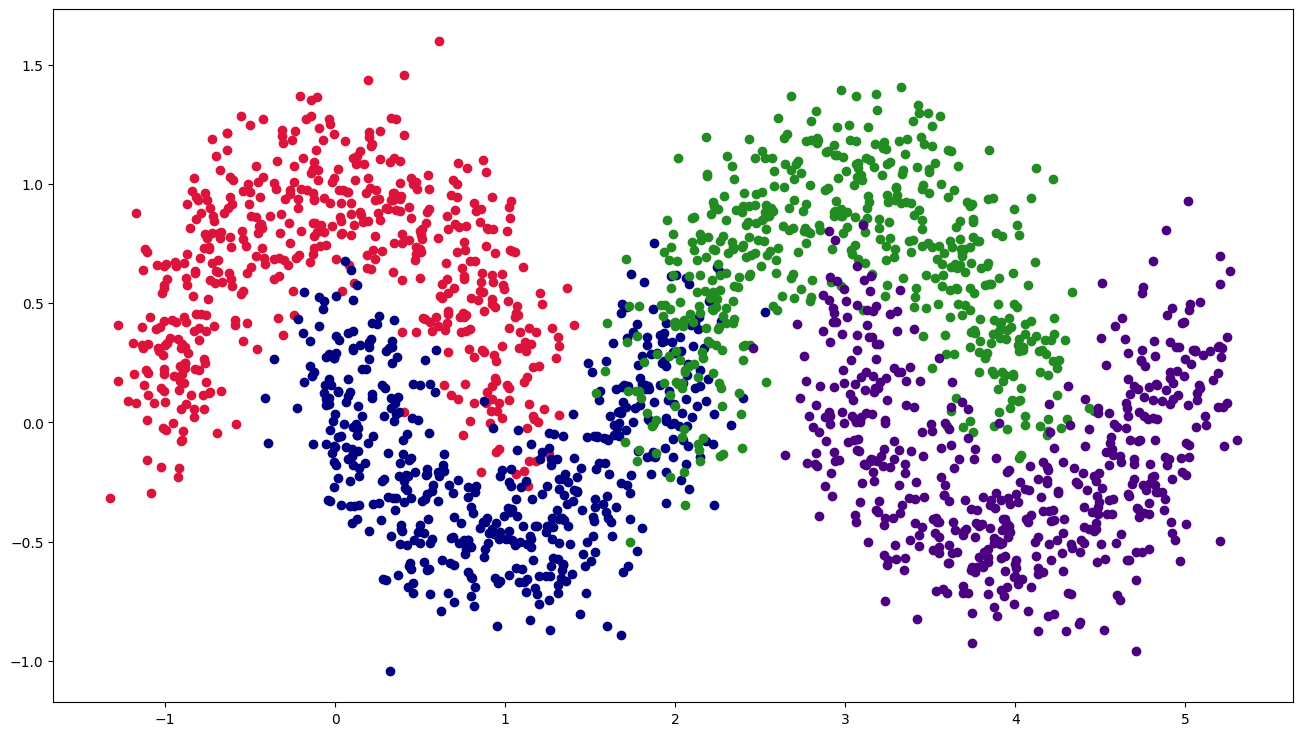

In [3]:
X, y = make_four_moons(2048, noise=.2)
fig, ax = plt.subplots(figsize=(16, 9))
colors = ["crimson", "navy", "forestgreen", "indigo"]
for i in range(4):
    ax.plot(X[y == i, 0], X[y == i, 1], 'o', c=colors[i])

We build graphs similar to what we did for decision tress
because we will us the decision tree as the basic model of our ensembles.
The Random Forest will split the trees for as long as possible,
resulting in overfitting in each tree.
But the result of averaging several trees that overfit in different
places of the datasset produces a very good classification.
On thing to note is that we achieve boundaries between classes
(i.e. the decision function) that is not straight everywhere
as it was with a single decision tree.
We use $30$ trees in the Random Forest constructions,
provided in the argument.

The Ada Boost attempts to find a good representation
hence it will keep the straight lines.
We explicitly give the type of model Ada Boost should use,
a tree that can split only *thrice* (`max_depth=3`).
Since our data has several places where three classes are present
at the same time,
splitting only once would never be able to capture the dataset structure.
We use $20$ such trees.

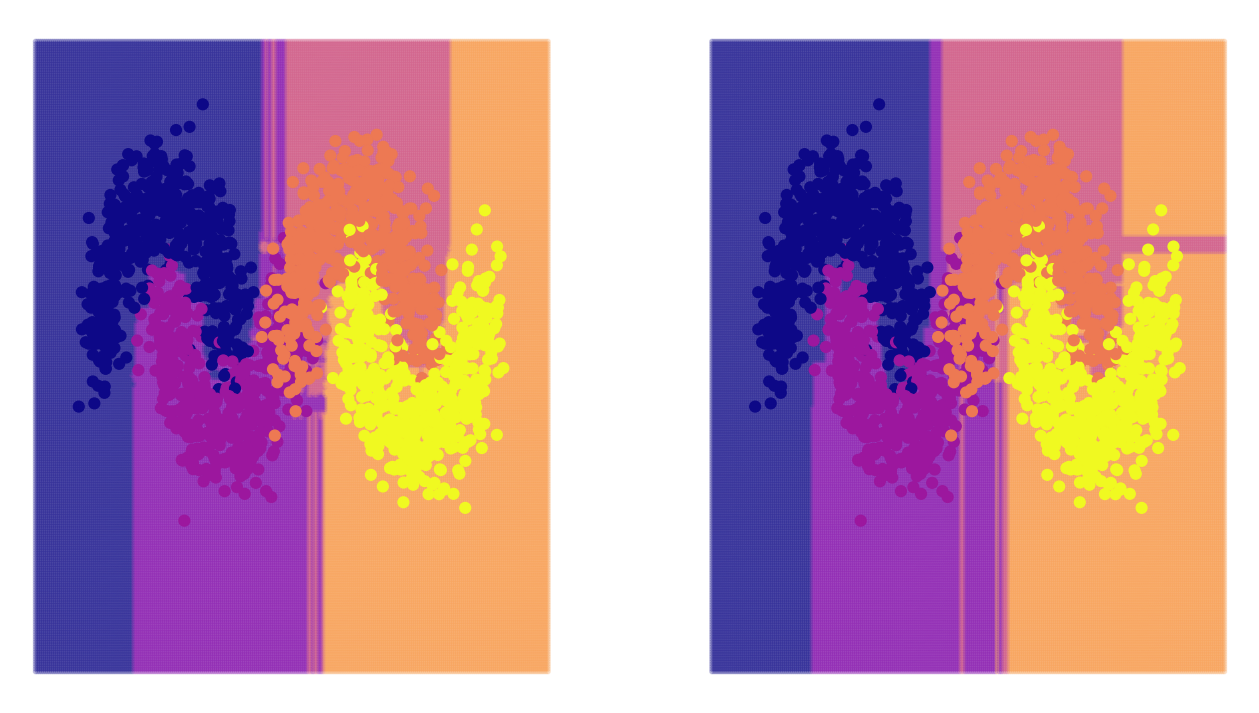

In [4]:
model_l = RandomForestClassifier(n_estimators=30)
model_r = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=20)
model_l.fit(X, y)
model_r.fit(X, y)

fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(16, 9))
gx = np.linspace(-2, 6, 256)
gy = np.linspace(-2, 2, 256)
gx, gy = np.meshgrid(gx, gy)
gx, gy = gx.reshape(-1), gy.reshape(-1)

y_hat = model_l.predict(np.c_[gx, gy])
ax_l.scatter(gx, gy, c=plt.cm.plasma(y_hat / 4), alpha=0.2, s=10)
ax_l.scatter(X[:, 0], X[:, 1], s=60, c=y, cmap="plasma")
ax_l.axis('off')

y_hat = model_r.predict(np.c_[gx, gy])
ax_r.scatter(gx, gy, c=plt.cm.plasma(y_hat / 4), alpha=0.2, s=10)
ax_r.scatter(X[:, 0], X[:, 1], s=60, c=y, cmap="plasma")
ax_r.axis("off");

At first sight the model produce by the random forest looks better.
Both models certainly overfit a lot less than the single decision tree.
The Ada Boost ensemble model attempted to identify the structure
but straight lines are not a good way of separating this dataset.

Instead we can try a base model that does not separate using straight line.
We did see the logistic regression and that it has a decision function that is curved.
We will take the logistic regression and use it as the base model for boosting,
the `C=10` is slight regularization for the logistic regression.
And we train $20$ such logistic regressions in Ada Boost scheme.

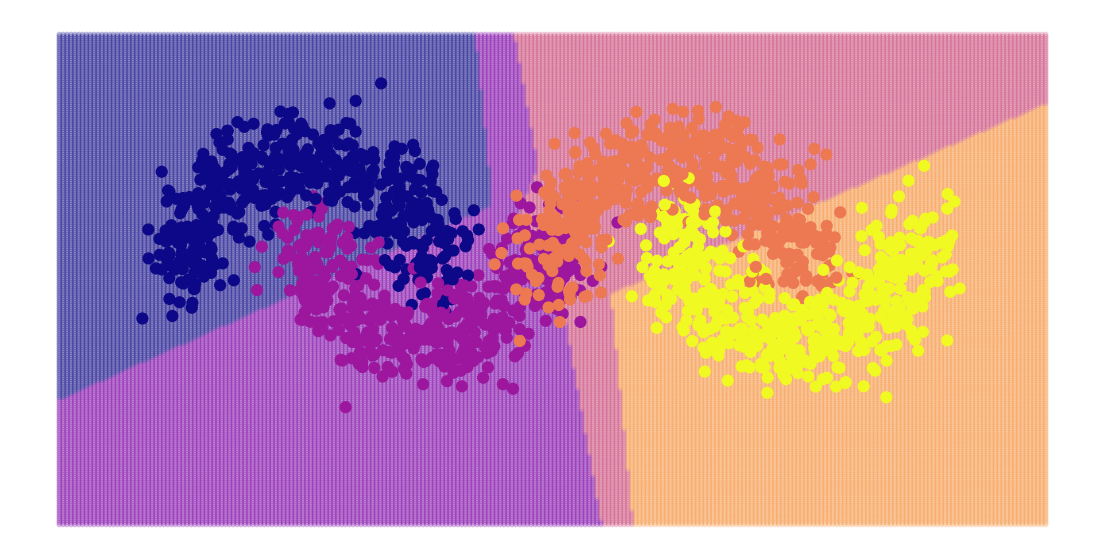

In [5]:
from sklearn.linear_model import LogisticRegression

model = AdaBoostClassifier(LogisticRegression(C=10), n_estimators=10)
model.fit(X, y)

fig, ax = plt.subplots(figsize=(14, 7))
gx = np.linspace(-2, 6, 256)
gy = np.linspace(-2, 2, 256)
gx, gy = np.meshgrid(gx, gy)
gx, gy = gx.reshape(-1), gy.reshape(-1)

y_hat = model.predict(np.c_[gx, gy])
ax.scatter(gx, gy, c=plt.cm.plasma(y_hat / 4), alpha=0.2, s=10)
ax.scatter(X[:, 0], X[:, 1], s=60, c=y, cmap="plasma")
ax.axis("off");

And we recover the structure of the dataset:
there is one (blue) class at the top-left,
one (violet) at the bottom-left-middle,
one (orange) at the top-right-middle,
and one (yellow) at the bottom-right.
It may not appear to be a good model at first sight,
and it may indeed not be a good one if new data is close to the original moons.
Yet, if new data extends far away of the moons in the dataset
the generalization of the model is high.

## More Ensembles

There are several other schemes of ensemble training.

- A **Bagging** approach (`BaggingClassifier`/`BaggingRegressor` in `sklearn`)
  is a random forest composed of models that are not necessarily trees.
  In other words, training several models *of the same type* with subsamples of data
  is called the bagging scheme of ensembles.
  When the subsamples of data do not use bootstrapping the technique is sometimes
  referred to a pasting.

- The **Voting** approach (`VotingClassifier`/`VotingRegressor` in `sklearn`)
  consists of training several models of *different types* within the same ensemble.
  For example, an ensemble of kNN and LogisticRegression.
  One can directly assign weights to the votes from different models.

A tuned ensemble will perform better than a simple classifier, in most cases.